# arXiv Paper Classification - Model Development

This notebook details the end-to-end process of training a `SciBERT` model to classify academic papers from arXiv into one of five computer science categories.

## 1. Setup & Config

In [ ]:
!pip uninstall transformers -y
!pip install transformers datasets scikit-learn pandas torch evaluate accelerate -q

Found existing installation: transformers 4.57.2
,Uninstalling transformers-4.57.2:
,  Successfully uninstalled transformers-4.57.2
,     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
,   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 41.7 MB/s eta 0:00:00
,

In [ ]:
import os
import gc
import json
from datetime import datetime
import random
import logging
import pandas as pd
import numpy as np
import torch
import shutil
import evaluate
from google.colab import files, drive
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
logger = logging.getLogger(__name__)

In [ ]:
class Config:
    TARGET_CATEGORIES = {
        'cs.LG',  # Machine Learning
        'cs.CV',  # Computer Vision and Pattern Recognition
        'cs.AI',  # Artificial Intelligence
        'cs.CL',  # Computation and Language (NLP)
        'cs.NE'   # Neural and Evolutionary Computing
    }
    SAMPLES_PER_CATEGORY = 5000
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"
    MAX_LENGTH = 256
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WEIGHT_DECAY = 0.01
    SEED = 1337
    RAW_DATA_FILE = "arxiv-metadata-oai-snapshot.json"
    OUTPUT_DIR = "scibert-finetuned-arxiv"
    FINAL_MODEL_DIR = "final_model_artifacts"

def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    logger.info(f"Seed set to {seed_value}.")
set_seed(Config.SEED)
def cleanup_memory():
    logger.info("Cleaning up GPU memory.")
    gc.collect()
    torch.cuda.empty_cache()

## 2. Data Acquisition, Loading, and Validation
Here, we download the raw arXiv dataset from Kaggle, process the large JSON file efficiently, and perform validation to ensure data quality before proceeding.

In [ ]:
logger.info("Please upload your kaggle.json file.")
try:
    if not os.path.exists('/root/.kaggle'):
        os.makedirs('/root/.kaggle')
        os.chmod('/root/.kaggle', 0o700)
    uploaded = files.upload()
    shutil.move(list(uploaded.keys())[0], '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    logger.info("Kaggle API setup complete.")
except Exception as e:
    logger.error(f"Error setting up Kaggle API: {e}")
logger.info("Downloading arXiv dataset...")
!kaggle datasets download -d Cornell-University/arxiv -f arxiv-metadata-oai-snapshot.json --unzip

def load_and_filter_data(file_path, target_categories, samples_per_category):
    abstracts, categories = [], []
    category_counts = {cat: 0 for cat in target_categories}
    with open(file_path, 'r') as f:
        for line in f:
            try:
                paper = json.loads(line)
                primary_category = paper.get('categories', '').split(' ')[0]
                if (primary_category in target_categories and
                    category_counts[primary_category] < samples_per_category):
                    abstracts.append(paper.get('abstract', ''))
                    categories.append(primary_category)
                    category_counts[primary_category] += 1
                if all(count >= samples_per_category for count in category_counts.values()):
                    logger.info("Sufficient samples collected for all categories. Exiting early.")
                    break
            except (json.JSONDecodeError, AttributeError):
                continue
    return pd.DataFrame({'abstract': abstracts, 'category': categories})

def validate_data(df, target_categories, expected_samples):
    expected_total = len(target_categories) * expected_samples
    assert not df.empty, "DataFrame is empty."
    assert len(df) == expected_total, f"Expected {expected_total} samples, got {len(df)}"
    assert df['abstract'].notna().all(), "Found null values in 'abstract' column."
    category_counts = df['category'].value_counts()
    assert (category_counts == expected_samples).all(), f"Dataset is not balanced: {category_counts}"
    logger.info("Data validation passed successfully.")

try:
    logger.info("Starting data loading and filtering process...")
    df_balanced = load_and_filter_data(
        Config.RAW_DATA_FILE,
        Config.TARGET_CATEGORIES,
        Config.SAMPLES_PER_CATEGORY
    )
    validate_data(df_balanced, Config.TARGET_CATEGORIES, Config.SAMPLES_PER_CATEGORY)
    logger.info(f"Successfully loaded and validated {len(df_balanced)} samples.")
    cleanup_memory()
except FileNotFoundError:
    logger.error(f"Dataset file '{Config.RAW_DATA_FILE}' not found.")
except AssertionError as e:
    logger.error(f"Data validation failed: {e}")

Saving kaggle.json to kaggle.json
,Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
,License(s): CC0-1.0
,
,Downloading arxiv-metadata-oai-snapshot.json to /content
,100% 4.61G/4.63G [00:48<00:00, 61.1MB/s]
,100% 4.63G/4.63G [00:48<00:00, 102MB/s] 


## 3. Exploratory Data Analysis (EDA)
We perform a brief EDA to understand the distribution of abstract lengths, which informs our choice for the `MAX_LENGTH` parameter during tokenization.

In [ ]:
logger.info("Performing EDA on abstract token lengths.")
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_CHECKPOINT)
token_lengths = [len(tokenizer(text).input_ids) for text in df_balanced['abstract']]
plt.figure(figsize=(12, 7))
sns.histplot(token_lengths, bins=50)
plt.title('Distribution of Abstract Token Lengths')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.axvline(x=Config.MAX_LENGTH, color='r', linestyle='--', label=f'Chosen MAX_LENGTH = {Config.MAX_LENGTH}')
plt.legend()
plt.show()
logger.info(f"EDA complete. The MAX_LENGTH of {Config.MAX_LENGTH} appears to be a reasonable choice.")

## 4. Data Preprocessing
This section covers splitting the data into training, validation, and test sets, and then tokenizing the text data into a format suitable for the Transformer model.

In [ ]:
test_val_size = 1.0 - Config.TRAIN_SPLIT
relative_test_size = (1 - Config.TRAIN_SPLIT - Config.VAL_SPLIT) / test_val_size
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=test_val_size,
    random_state=Config.SEED,
    stratify=df_balanced['category']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=relative_test_size,
    random_state=Config.SEED,
    stratify=temp_df['category']
)
logger.info(f"Data split complete: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
})
labels = sorted(df_balanced['category'].unique().tolist())
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
logger.info(f"Label mappings created: {label2id}")
def preprocess_function(examples):
    tokenized_inputs = tokenizer(
        examples["abstract"],
        max_length=Config.MAX_LENGTH,
        truncation=True,
        padding="max_length"
    )
    tokenized_inputs["labels"] = [label2id[label] for label in examples["category"]]
    return tokenized_inputs
logger.info("Applying tokenization to all dataset splits...")
processed_datasets = raw_datasets.map(preprocess_function, batched=True)
processed_datasets = processed_datasets.remove_columns(['abstract', 'category'])
processed_datasets.set_format("torch")
logger.info("Preprocessing complete.")

## 5. Model Training
We load the pre-trained SciBERT model, define training arguments and evaluation metrics, and launch the fine-tuning process using the Hugging Face `Trainer` API.

In [ ]:
logger.info(f"Loading pre-trained model: {Config.MODEL_CHECKPOINT}")
model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

training_args = TrainingArguments(
    output_dir=Config.OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=Config.LEARNING_RATE,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    num_train_epochs=Config.NUM_EPOCHS,
    weight_decay=Config.WEIGHT_DECAY,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    seed=Config.SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logger.info("Starting model training...")
train_output = trainer.train()
logger.info(f"Training complete. Final metrics: {train_output.metrics}")

## 6. Model Evaluation
After training, we evaluate the best-performing model on the held-out test set to get a final, unbiased measure of its performance. We also generate a confusion matrix to analyze its predictions in more detail.

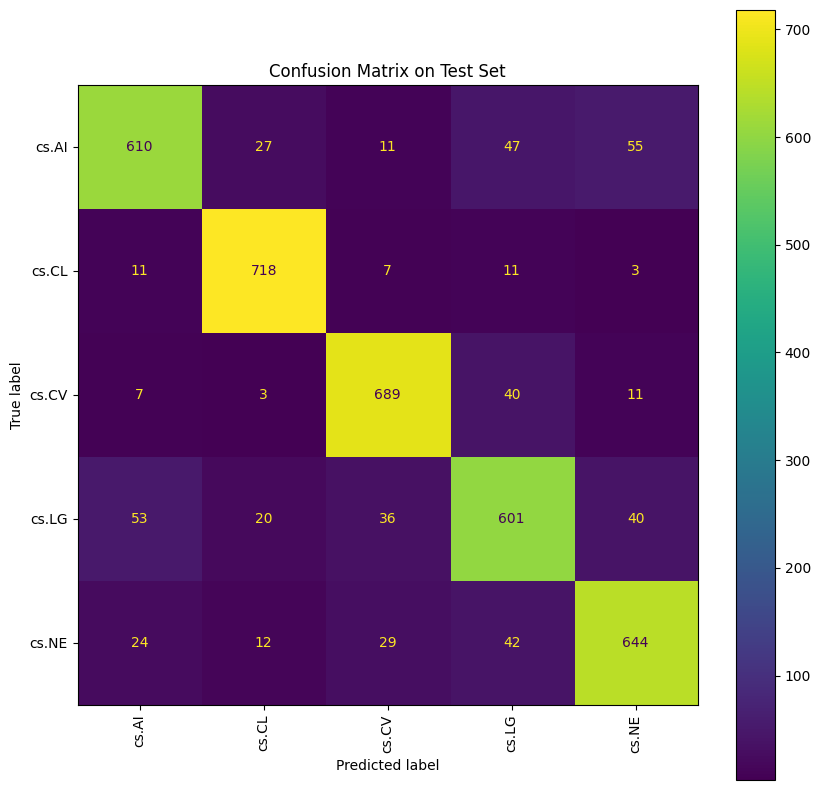

In [ ]:
logger.info("Evaluating the best model on the test set...")
test_results = trainer.evaluate(eval_dataset=processed_datasets["test"])
logger.info(f"--- Final Test Set Performance ---")
logger.info(f"Loss: {test_results['eval_loss']:.4f}")
logger.info(f"Accuracy: {test_results['eval_accuracy']:.4f}")
logger.info(f"F1-Score: {test_results['eval_f1']:.4f}")
logger.info("Generating confusion matrix...")
test_predictions = trainer.predict(processed_datasets["test"])
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix on Test Set')
plt.show()

## 7. Save Final Artifacts and Experiment Metadata
We save the best-performing model and its tokenizer to a clean directory for easy deployment. We also save a metadata file containing all configuration and results for this experiment.

In [ ]:
logger.info(f"Saving final model and tokenizer to '{Config.FINAL_MODEL_DIR}'...")
trainer.save_model(Config.FINAL_MODEL_DIR)
tokenizer.save_pretrained(Config.FINAL_MODEL_DIR)
logger.info("Artifacts saved successfully.")

def save_experiment_metadata(output_dir, config, results, train_output):
    config_dict = {}
    for k, v in vars(config).items():
        if not k.startswith('__'):
            if isinstance(v, set):
                config_dict[k] = list(v)
            else:
                config_dict[k] = v
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'project_phase': 'Phase 1 - Model Training',
        'configuration': config_dict,
        'final_test_results': results,
        'full_training_metrics': train_output.metrics
    }
    metadata_path = os.path.join(output_dir, 'experiment_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    logger.info(f"Experiment metadata saved to '{metadata_path}'")
save_experiment_metadata(Config.OUTPUT_DIR, Config, test_results, train_output)

## 8. Backup & Export
As a final step, we copy all important assets (the final model, all training checkpoints, and experiment metadata) for safekeeping and for use in subsequent project phases.

In [ ]:
PACKAGE_DIR_NAME = 'deployment_package'
PACKAGE_ZIP_NAME = 'project_2_deployment_package'
logger.info(f"Assembling essential artifacts into '{PACKAGE_DIR_NAME}'...")
os.makedirs(PACKAGE_DIR_NAME, exist_ok=True)
try:
    shutil.copytree(Config.FINAL_MODEL_DIR, os.path.join(PACKAGE_DIR_NAME, Config.FINAL_MODEL_DIR))
    logger.info(f"-> Copied '{Config.FINAL_MODEL_DIR}'")
except FileExistsError:
    logger.warning(f"-> Directory '{Config.FINAL_MODEL_DIR}' already exists in package, skipping copy.")
try:
    metadata_source_path = os.path.join(Config.OUTPUT_DIR, 'experiment_metadata.json')
    metadata_dest_path = os.path.join(PACKAGE_DIR_NAME, 'experiment_metadata.json')
    shutil.copy(metadata_source_path, metadata_dest_path)
    logger.info("-> Copied 'experiment_metadata.json'")
except FileNotFoundError:
    logger.error("-> Could not find 'experiment_metadata.json' to copy.")
logger.info(f"Creating zip file: '{PACKAGE_ZIP_NAME}.zip'...")
shutil.make_archive(
    base_name=PACKAGE_ZIP_NAME,
    format='zip',
    root_dir=PACKAGE_DIR_NAME
)
logger.info("Zip file created successfully.")
logger.info("Starting download of the deployment package...")
files.download(f'{PACKAGE_ZIP_NAME}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>